In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import numpy as np

# Load dataset
df = pd.read_csv("dataset.csv")

# Drop unnecessary columns
df = df.drop(columns=["Unnamed: 0"], errors="ignore")

# Remove duplicates
df = df.drop_duplicates()

# Separate features & target variable
X = df.drop(columns=["label"])
y = df["label"]

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize XGBoost model
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)

# Train the model
xgb.fit(X_train, y_train)

# Get predictions
xgb_pred = xgb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, xgb_pred)
rms = np.sqrt(mean_squared_error(y_test, xgb_pred))

# Display results
print(f"XGBoost Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, xgb_pred))
print(f"XGBoost RMS: {rms:.4f}")


C:\Users\ykuma\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [15:40:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9776
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     52311
           1       0.99      1.00      1.00       424
           2       1.00      1.00      1.00      9894
           3       0.88      0.88      0.88      6416

    accuracy                           0.98     69045
   macro avg       0.96      0.97      0.97     69045
weighted avg       0.98      0.98      0.98     69045

XGBoost RMS: 0.4489


In [2]:
# Train prediction
xgb_train_pred = xgb.predict(X_train)
train_accuracy = accuracy_score(y_train, xgb_train_pred)
test_accuracy = accuracy_score(y_test, xgb_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Train Accuracy: 0.9888
Test Accuracy: 0.9776


C:\Users\ykuma\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:43:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ykuma\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:43:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ykuma\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:43:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\ykuma\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:43:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

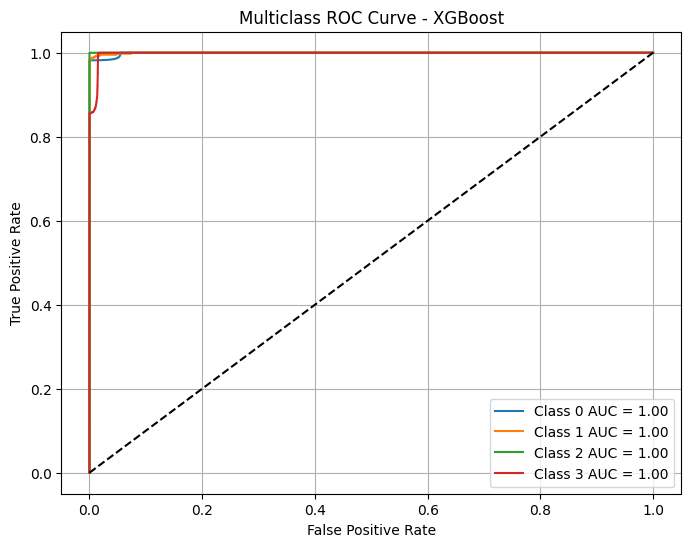

In [4]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize classes
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]

# Split again using binarized y
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_scaled, y_bin, test_size=0.2, random_state=42)

# Train One-vs-Rest XGBoost
xgb_multi = OneVsRestClassifier(XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42))
xgb_multi.fit(X_train_bin, y_train_bin)
y_score = xgb_multi.predict_proba(X_test_bin)

# Plot ROC for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} AUC = {roc_auc:.2f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve - XGBoost")
plt.legend()
plt.grid()
plt.show()



Feature Importances:
              Feature  Importance
11      output_count    0.628987
0            balance    0.119239
20       fee_per_kwu    0.064979
8        is_coinbase    0.062640
21   fee_per_kwu_usd    0.057822
3           block_id    0.050330
22         cdd_total    0.005185
1           rec/sent    0.004657
7          lock_time    0.001467
6            version    0.001081
4               size    0.000899
15  output_total_usd    0.000834
10       input_count    0.000307
2             amount    0.000246
19    fee_per_kb_usd    0.000194
14      output_total    0.000188
5             weight    0.000178
12       input_total    0.000174
18        fee_per_kb    0.000167
13   input_total_usd    0.000138
16               fee    0.000113
17           fee_usd    0.000103
9        has_witness    0.000071


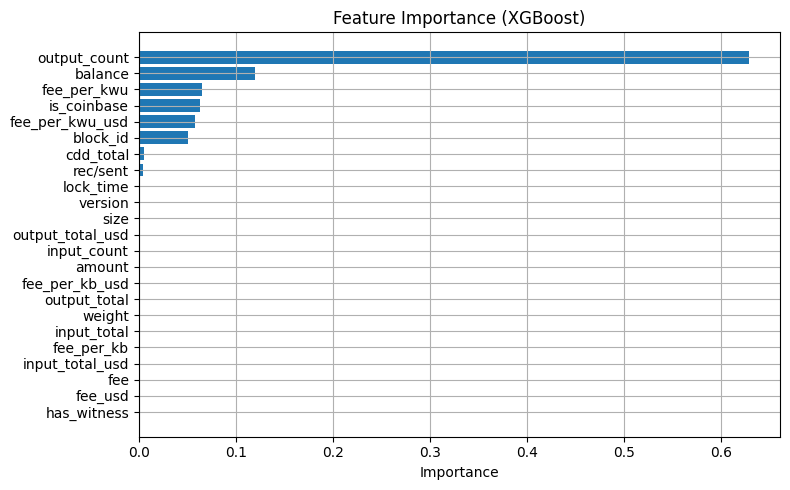

In [5]:
# Feature importance from XGBoost
importances = xgb.feature_importances_
features = df.drop(columns=["label"]).columns

importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importances:\n", importance_df)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.title("Feature Importance (XGBoost)")
plt.gca().invert_yaxis()
plt.grid()
plt.tight_layout()
plt.show()
